In [1]:
%run init_notebookspace.py

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\bayes_filter\data


In [2]:
import numpy as np
import matplotlib.pyplot as plt

Traking a 2D robot

We are tracking a robot moving on an x,y coordinate system, the following generates movement data with some noise

In [3]:
from numpy.random import randn

class PosSensor(object):
    def __init__(self, pos=(0, 0), vel=(0, 0), noise_std=1.):
        self.vel = vel
        self.noise_std = noise_std
        self.pos = [pos[0], pos[1]]
        
    def read(self):
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]
        
        return [self.pos[0] + randn() * self.noise_std,
                self.pos[1] + randn() * self.noise_std]

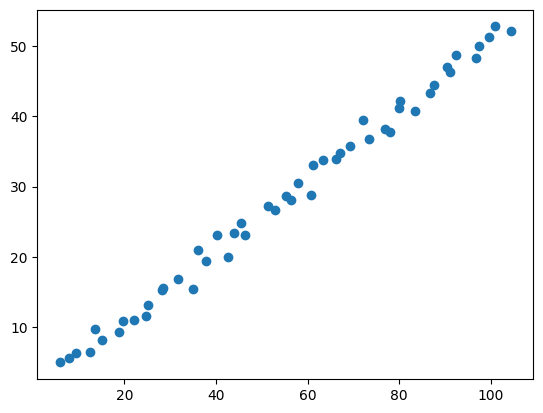

In [4]:
pos, vel = (4, 3), (2, 1)
sensor = PosSensor(pos, vel, noise_std=1)
pos = np.array([sensor.read() for _ in range(50)])
plt.scatter(pos[:, 0], pos[:, 1]);

The state includes x,y and their respective velocity, which we assume to be constant. This translates to the following transition equation:

$$
\begin{bmatrix}x \\ \dot x \\ y \\ \dot y\end{bmatrix} = \begin{bmatrix}1& \Delta t& 0& 0\\0& 1& 0& 0\\0& 0& 1& \Delta t\\ 0& 0& 0& 1\end{bmatrix}\begin{bmatrix}x \\ \dot x \\ y \\ \dot y\end{bmatrix}
$$

Filter implementation

In [5]:
from src.classes import KalmanFilterBase

In [6]:
tracker = KalmanFilterBase(4, 2)

transiation equation

In [7]:
dt = 1.
tracker.F = np.array([[1, dt, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, dt],
                      [0, 0, 0, 1]])

process noise matrix: we assume time invariant white noise

In [8]:
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

q = Q_discrete_white_noise(dim=2, dt=dt, var=0.001)
tracker.Q = block_diag(q, q)
print(tracker.Q)

[[0.00025 0.0005  0.      0.     ]
 [0.0005  0.001   0.      0.     ]
 [0.      0.      0.00025 0.0005 ]
 [0.      0.      0.0005  0.001  ]]


controll function, omitted for now

In [9]:
tracker.B = np.zeros((4,4))
tracker.u = np.zeros((4,1))

measurement function: measurement are assumed to be in feet, the function H is translating this to meters

In [10]:
tracker.H = np.array([[1/0.3048, 0, 0,        0],
                      [0,        0, 1/0.3048, 0]])

measurement noise matrix

In [11]:
tracker.R = np.array([[5., 0],
                      [0, 5]])

setting the inital position

In [16]:
tracker.x = np.array([[0, 0, 0, 0]]).T
tracker.P = np.eye(4) * 500.

run filter

In [17]:
tracker.run(pos[0])

(array([[1.80215182, 1.51545809],
        [0.90107659, 0.75772962],
        [1.80215182, 1.51545809],
        [0.90107659, 0.75772962]]),
 array([[4.64299526e-01, 2.32149937e-01, 0.00000000e+00, 0.00000000e+00],
        [2.32149937e-01, 2.50116638e+02, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 4.64299526e-01, 2.32149937e-01],
        [0.00000000e+00, 0.00000000e+00, 2.32149937e-01, 2.50116638e+02]]))

In [13]:
xf, covf = [], []
for item in pos:
    x, P = tracker.run(item)
    xf.append(x)
    covf.append(P)
    
xf = np.array(xf)
covf = np.array(covf)

AssertionError: (4x1) does not correspond to (4, 2)

In [ ]:
plt.scatter(xf[:,0].reshape(-1), xf[:,1].reshape(-1))
plt.scatter(pos[:,0].reshape(-1), pos[:,1].reshape(-1))

## Filterpy Implentation

In [56]:
from filterpy.kalman import KalmanFilter

In [63]:
ftracker = KalmanFilter(4, 2)

In [70]:
ftracker.F = tracker.F
# ftracker.Q = tracker.Q

# ftracker.B = tracker.B
# ftracker.u = tracker.u

ftracker.H = tracker.H
ftracker.R = tracker.R

ftracker.x = np.array([[0, 0, 0, 0]]).T
ftracker.P = np.eye(4) * 500.


In [71]:
# ftracker.predict()
# ftracker.update(pos[1])

In [72]:
ftracker.batch_filter(pos)

(array([[[ 1.80215182],
         [ 0.90107659],
         [ 1.51545809],
         [ 0.75772962]],
 
        [[ 2.41982888],
         [ 0.61846298],
         [ 1.72815593],
         [ 0.21420932]],
 
        [[ 2.89846943],
         [ 0.53462004],
         [ 1.91336402],
         [ 0.19681906]],
 
        [[ 3.70495256],
         [ 0.65126351],
         [ 2.0022776 ],
         [ 0.15052197]],
 
        [[ 4.20794235],
         [ 0.60161407],
         [ 2.64198995],
         [ 0.31432734]],
 
        [[ 4.71838659],
         [ 0.57647296],
         [ 2.71024782],
         [ 0.24647092]],
 
        [[ 5.49231095],
         [ 0.62306   ],
         [ 2.91111096],
         [ 0.23571014]],
 
        [[ 6.06426332],
         [ 0.61242836],
         [ 3.2199966 ],
         [ 0.25093244]],
 
        [[ 6.69333335],
         [ 0.61555887],
         [ 3.42783994],
         [ 0.24282684]],
 
        [[ 7.39095642],
         [ 0.62983189],
         [ 3.62555295],
         [ 0.23498041]],
 
        [[